## Description
Implementation of Bayesian adaptive quantum state tomography, for the simplest case: a single qubit pure state. 
Papers used: Theory: https://journals.aps.org/pra/pdf/10.1103/PhysRevA.85.052120?casa_token=SUmrjNskZXoAAAAA%3AyCeVTr5FWKwsy7rqy6o9tPvdW6VFobUCdhJpHy46h3SWXOijIG9rtcobn0dCU0XtFW3O1g-_Plw3LTU (ref 1)

Experimental implementation: 
https://journals.aps.org/pra/pdf/10.1103/PhysRevA.93.012103?casa_token=8YGIpZy6iu8AAAAA%3AmkDZ6juztVNSZAVtN4HLs1RCKcJ90SYJ0hNLcJxJnguSkMBQXWpA53gkau3T1JKLMqcXds-4xI0Y8WI (ref 2)


In [306]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import random_statevector
from qiskit.quantum_info import state_fidelity
from scipy import stats
from numpy import cos, sin, exp, pi, sqrt, log
from qiskit import QuantumCircuit
from scipy.optimize import minimize
rng = np.random.default_rng()

## QST of a single qubit pure state
- The simplest example: QST of a random qubit pure state
- Use projective measurements, allow for X, Y, and Z rotations
- Use 100 particles (posterior samples)

First, initialize a random hidden state:

In [2]:
n_qubits = 1
hidden_state = random_statevector(2 ** n_qubits).data
hidden_state

array([0.50445654+0.56632871j, 0.52653022+0.38413711j])

Then, initialize 100 random particles, and their weights:

In [76]:
def initialize_particles(n_particles = 100):
    return np.array([random_statevector(2).data for i in range(n_particles)]), np.ones(n_particles) / n_particles


particle_pos, particle_weights = initialize_particles(n_particles = 100)

print(f"Positions: {particle_pos[:10]} \n")
print(f"Weights: {particle_weights[:10]}\n")
print(f"fidelity test: {state_fidelity(particle_pos[0], hidden_state)}\n")

Positions: [[ 0.40178487+0.27976773j -0.87117182+0.03685896j]
 [ 0.61770176-0.70774028j  0.31880686+0.12613653j]
 [-0.80572946+0.55665216j -0.12090587+0.16223496j]
 [-0.15049669-0.08416996j -0.71238309-0.68027678j]
 [-0.96382121-0.19296651j -0.16335353+0.08442885j]
 [-0.60697598+0.27999133j -0.58741206+0.45621497j]
 [ 0.81967565+0.13585616j -0.20017606-0.51923451j]
 [ 0.1794431 +0.04673535j -0.70654241+0.68294494j]
 [ 0.53359427+0.6645701j   0.15780541+0.49871955j]
 [-0.20487987+0.61659015j  0.35766151-0.67076006j]] 

Weights: [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]

fidelity test: 0.07859212914409573



Define the entropy:

In [42]:
def entropy(probs):
    return -np.sum(probs * np.log(probs), axis = -1)

print(f"Prior entropy: {entropy(particle_weights)}")

Prior entropy: 6.907755278982134


Define an arbitrary qubit measurement: Measuring in (theta, phi) direction is equivalent to applying the following unitary, with both between 0 and pi, and measuring in z basis

In [43]:
def orient_measure(theta, phi):
    return np.array([[cos(theta/2), sin(theta/2)*exp(-phi * 1j)],
                     [-sin(theta/2), cos(theta/2)*exp(-phi * 1j)]])

#TEST
theta = 0.67 * pi
phi = 0.345 * pi
measure_direction = [cos(theta/2), sin(theta/2) * exp(phi * 1j)]
test_state = random_statevector(2)

print(f"Prob of measurement in measure_direction: {state_fidelity(test_state, measure_direction)}")
print(f"Prob of |0> measurement after rotating test_state: {np.abs(orient_measure(theta, phi) @ test_state.data)[0] ** 2}")

Prob of measurement in measure_direction: 0.8270232343278662
Prob of |0> measurement after rotating test_state: 0.8270232343278662


Probabilistic measurement for given configuration:

In [68]:
def measure_along_axis(state, configuration):
    orient_unitary = orient_measure(configuration[0], configuration[1])
    
    prob_0 = np.abs((orient_unitary @ state)[0]) ** 2
    return int(rng.random() > prob_0)

##Test
n_steps = 100_000
count = 0
configuration = [pi/2, pi/2]
state = [1/np.sqrt(2), -1j/np.sqrt(2)]

for i in range(n_steps):
    count +=measure_along_axis(state, configuration)
    
count/n_steps

1.0

Calculate likelihood of a measurement: probability of a measurement occuring given each particle in particle_pos, and measurement configuration

In [69]:
def likelihood(particle_pos, configuration, result):
    orient_unitary = orient_measure(configuration[0], configuration[1])
    particle_pos = particle_pos @ np.transpose(orient_unitary)
    
    return np.abs(particle_pos[:, result]) ** 2

Define the particle weight update, based on the measurement and measurement configuration. Result is 0 (up in z axis) or 1 (down in z axis)

In [429]:
def update_weights(particle_pos, particle_weights, configuration, result):
    posterior = likelihood(particle_pos, configuration, result) * particle_weights
    return posterior / np.sum(posterior)

#Test measure: Measure along the hadamard axis, compare posterior probs with direct measurement in that axis
test1 = update_weights(particle_pos, particle_weights, [pi/2, pi/2], 1)[:10]

test2 = np.array([state_fidelity(particle, measure_result) for particle in particle_pos])[:10]
test1/test2

array([0.00195053, 0.00195053, 0.00195053, 0.00195053, 0.00195053,
       0.00195053, 0.00195053, 0.00195053, 0.00195053, 0.00195053])

Define the information gain function (equation 6 of ref 1) of a particular measurement configuration:

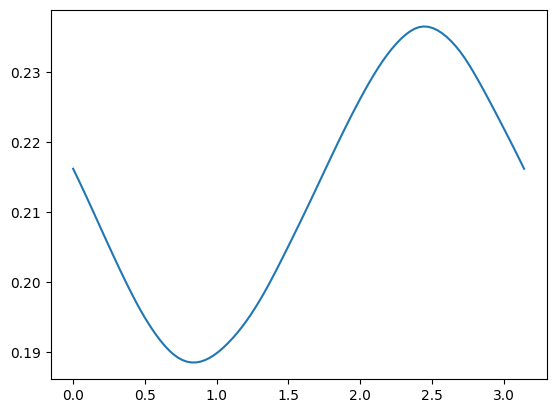

In [265]:
possible_results = [0, 1]
def info_gain(particle_pos, particle_weights, configuration):
    likelihoods = likelihood(particle_pos, configuration, possible_results)
    
    posterior = particle_weights[:, np.newaxis] * likelihoods
    uniformity = entropy(np.sum(posterior, axis = 0))
    
    confidence = np.sum(entropy(likelihoods) * particle_weights)
    return uniformity - confidence

##Test along various axis: We expect to see info_gain to change for different particle draws
particle_pos, particle_weights = initialize_particles()
y_angles = np.linspace(0, pi, 100)
z_angle = 0
info_gains = [info_gain(particle_pos, particle_weights, [y_angle, z_angle]) for y_angle in y_angles]

plt.plot(y_angles, info_gains)

Use scipy to optimize the info gain across possible phi and theta orientations

In [266]:
bounds = [[0, pi], [0, pi]]
def maximize_info_gain(particle_pos, particle_weights):
    optimized = minimize(lambda x: -info_gain(particle_pos, particle_weights, x), 
                         x0 = [pi/2, pi/2],
                         bounds = bounds)
    
    return optimized.x

maximize_info_gain(particle_pos, particle_weights)

array([0.74766512, 2.79650779])

### Test run 1
Maximizing info gain after several up, down measurements on z-axis, and several up-down measurements on x axis. Theoretically should choose a measurement in y-axis. 

In [323]:
n_measurements = 2
configs = [[0, 0], [0, 0], [pi/2, 0], [pi/2, 0]]
results = [0, 1, 0, 1]
particle_pos, particle_weights = initialize_particles(1000)

for config, result in zip(configs, results):
    particle_weights = update_weights(particle_pos, particle_weights, config, result)
    
theta, phi = maximize_info_gain(particle_pos, particle_weights)
print(f"Optimal theta: {theta/pi} pi, optimal phi: {phi/pi} pi")

Optimal theta: 0.48690107293042545 pi, optimal phi: 0.5164637581277448 pi


Let's plot the posterior across the bloch sphere (projected onto the XZ plane) after the measurements:

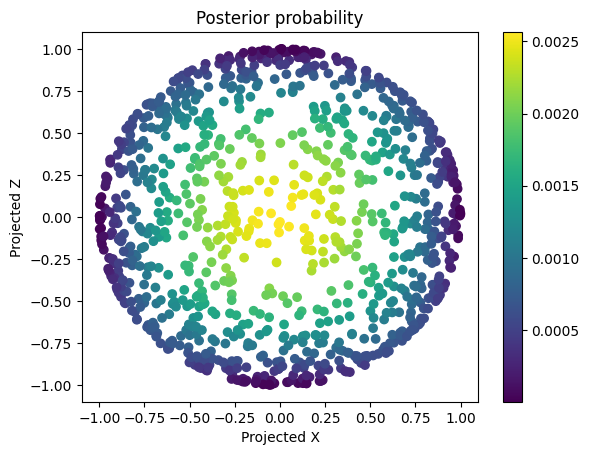

In [327]:
#Plot the posterior across the projected bloch sphere after the measurements!
def project(state):
    angle_0 = np.angle(state[0])
    angle_1 = np.angle(state[1])
    phi = angle_1 - angle_0
    
    mag_0 = np.abs(state[0])
    mag_1 = np.abs(state[1])
    theta = 2 * np.arctan(mag_1 / mag_0)
    
    return sin(theta) * cos(phi), cos(theta)

def plot_xz(particle_pos, particle_weights, ax):
    xz_states = np.array([project(state) for state in particle_pos])
    ax.set_xlabel("Projected X")
    ax.set_ylabel("Projected Z")
    ax.set_title("Posterior probability")
    sc = ax.scatter(xz_states[:, 0], xz_states[:, 1], c = particle_weights, cmap = 'viridis')
    plt.colorbar(sc, ax=ax)
    
    
fig, ax = plt.subplots()
plot_xz(particle_pos, particle_weights, ax)

And finally, let's look at what the information gain looks like for different values of phi and theta orientations:

Text(0.5, 1.0, 'Information Gain')

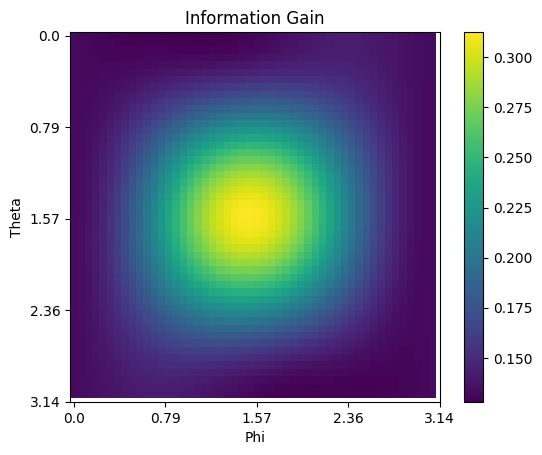

In [272]:
# Generate random values for each square
theta_arr = np.linspace(0, pi, 50)
phi_arr = np.linspace(0, pi, 50)
info_gains = [[info_gain(particle_pos, particle_weights, [theta, phi])
              for theta in theta_arr] 
              for phi in phi_arr]

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the plane with colors
im = ax.imshow(info_gains, cmap='viridis')

# Add a colorbar for reference
cbar = fig.colorbar(im)

# Set the range and tick values for the x and y axes
x_tick_values = np.linspace(0, 50, 5)  # Example tick values for x-axis
y_tick_values = np.linspace(0, 50, 5)  # Example tick values for y-axis
x_tick_labels = np.round(np.linspace(0, pi, 5), 2)
y_tick_labels = np.round(np.linspace(0, pi, 5), 2)

# Set x and y axis tick positions and labels
ax.set_xticks(x_tick_values)
ax.set_yticks(y_tick_values)
ax.set_xticklabels(x_tick_labels)
ax.set_yticklabels(y_tick_labels)

# Set x and y axis labels
ax.set_xlabel('Phi')
ax.set_ylabel('Theta')
ax.set_title("Information Gain")

### MC resampling

Need to resample the particles when their probabilities get too low, or else they aren't useful. We follow the Metropois Hastings sampling procedure of appendix C in ref 2 here. We resample when the effective sample size drops too low:

In [229]:
def effective_sample_size(particle_weights):
    return 1 / np.sum(particle_weights ** 2)

particle_pos, particle_weights = initialize_particles(1000)
effective_sample_size(particle_weights)

999.9999999999998

Make a function that draws the particles, according to their weights, N times

In [259]:
def redraw_particles(particle_pos, particle_weights):
    n_particles = len(particle_pos)
    indices = np.random.choice(np.arange(n_particles), 
                               p = particle_weights, 
                               size = n_particles)
    return particle_pos[indices], np.ones(n_particles) / n_particles

log-likelihood over all measurements so far:

In [337]:
def full_log_likelihood(particle_pos, configurations, results):
    likelihoods = np.zeros(len(particle_pos))
    
    for configuration, result in zip(configurations, results):
        likelihoods += np.log(likelihood(particle_pos, configuration, result))
        
    return likelihoods

#Test
configurations = [[0, 0], [0, 0], [pi/2, 0], [pi/2, 0]]
results = [1, 0, 1, 0]
particle_pos, particle_weights = initialize_particles(1000)
likelihoods = full_log_likelihood(particle_pos, configurations, results)



Draw the candidate positions for a step in MC:

In [418]:
#Draw next positions
def draw_next_pos(pos_curr, step_scale):
    random_vecs = np.random.normal(size = pos_curr.shape) + np.random.normal(size = pos_curr.shape) * 1j
    
    overlaps = np.einsum('ij,ij->i', np.conjugate(pos_curr), random_vecs)
    
    step_vecs = random_vecs - pos_curr * overlaps[:, np.newaxis]
    
    step_norms = (np.linalg.norm(step_vecs, axis = 1))
    
    step_vecs /= step_norms[:, np.newaxis]
    
    
    a = 1 - np.abs(np.random.normal(scale = step_scale, size = len(pos_curr)))
    a[(a < 0)] = 0
    
    b = sqrt(1 - a ** 2)
    
    return a[:, np.newaxis] * pos_curr + b[:, np.newaxis] * step_vecs

step_scale = 0.1
next_pos = draw_next_pos(particle_pos, step_scale)

print(f"Old positions:\n {particle_pos[:10]}\n")

print(f"New positions:\n {next_pos[:10]}\n")

print(f"Check norms: \n {np.linalg.norm(next_pos, axis = 1)[:10]}")

Old positions:
 [[ 0.93721443-0.29924762j  0.0236964 -0.17753439j]
 [ 0.78949108+0.45745012j  0.40814326-0.02936497j]
 [-0.44783642+0.687812j   -0.05497176+0.5686258j ]
 [-0.66955482-0.2773313j   0.68672789-0.05646686j]
 [ 0.83190971-0.4577554j  -0.28423212-0.13265869j]
 [-0.55512636+0.22036165j  0.46526708-0.65330085j]
 [-0.38496153+0.63497086j  0.39759796+0.53901065j]
 [-0.69343546-0.32577846j  0.57122683+0.29447508j]
 [-0.17489145+0.16552625j  0.80085531-0.54831088j]
 [-0.20740403-0.89672836j -0.06804215-0.3850092j ]]

New positions:
 [[ 0.92802651-0.28819627j -0.01138651-0.2357542j ]
 [ 0.79684107+0.47920566j  0.36305692-0.05996598j]
 [-0.46696707+0.57143989j  0.04973063+0.67299708j]
 [-0.78696159-0.14460277j  0.58585878+0.12865065j]
 [ 0.75742024-0.41816471j -0.45281649-0.21542998j]
 [-0.51861012+0.43854408j  0.54658423-0.48986561j]
 [-0.53426443+0.70900936j  0.3465034 +0.30298951j]
 [-0.40325861-0.53992176j  0.73743871-0.04528954j]
 [-0.50175973+0.45163772j  0.60635876-0.42022565

Take an MC step

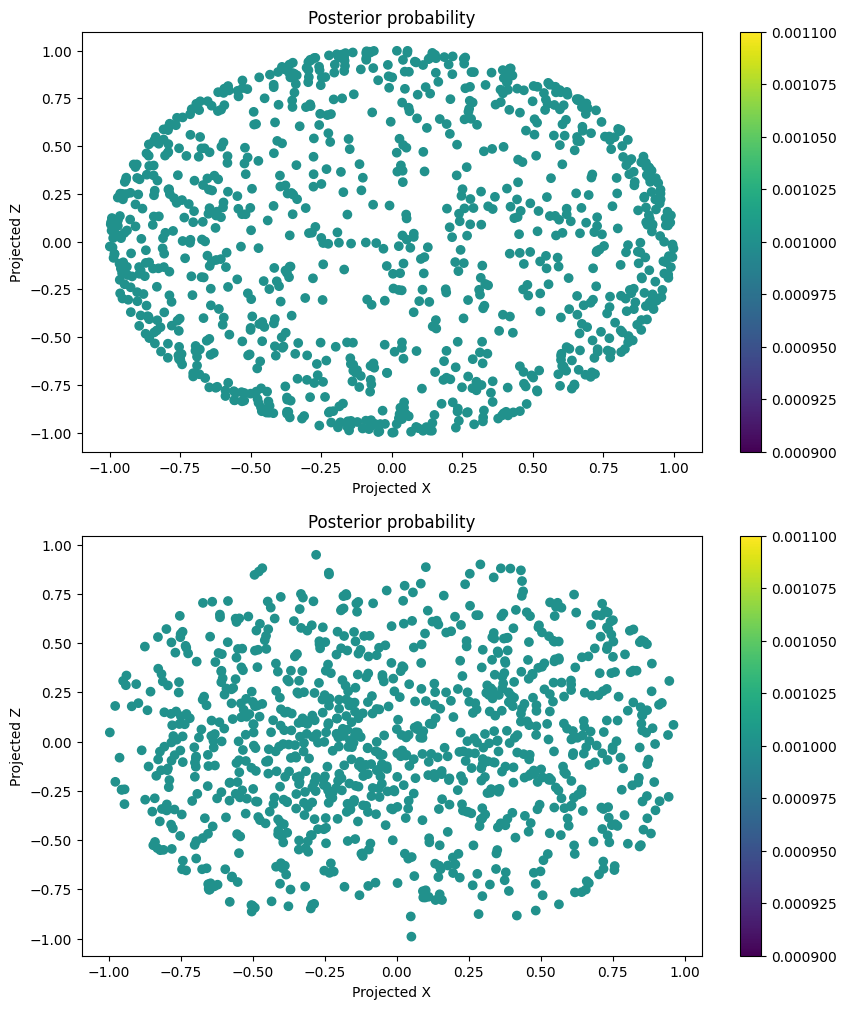

In [368]:
def mc_step(pos_curr, log_likelihoods_curr, configurations, results, step_scale):
    #Next positions
    pos_next = draw_next_pos(pos_curr, step_scale)
    
    log_likelihoods_next = full_log_likelihood(pos_next, configurations, results)
    
    acceptance_ratios = log_likelihoods_next - log_likelihoods_curr
    
#     print(pos_curr[:10])
#     print(pos_next[:10])
    
    rejected = (log(np.random.rand(len(pos_curr))) > acceptance_ratios)
    
    pos_next[rejected] = pos_curr[rejected]
    log_likelihoods_next[rejected] = log_likelihoods_curr[rejected]
    
    #print(np.sum(rejected))
    
    return pos_next, log_likelihoods_next


#Take one MC Step
configurations = [[0, 0], [0, 0], [pi/2, 0], [pi/2, 0], [0, 0], [0, 0], [pi/2, 0], [pi/2, 0]]
results = [1, 0, 1, 0, 1, 0]
step_scale = 0.1
fig, ax = plt.subplots(2, figsize = (10, 12))

particle_pos, particle_weights = initialize_particles(1000)
log_likelihoods = full_log_likelihood(particle_pos, configurations, results)
plot_xz(particle_pos, particle_weights, ax[0])

for i in range(10000):
    particle_pos, log_likelihoods = mc_step(particle_pos, log_likelihoods, configurations, results, step_scale)

plot_xz(particle_pos, particle_weights, ax[1])

Estimate the distribution size of a set of pure states as sum of standard deviations squared of real and complex parts (without global phase factor)

In [408]:
def dist_size(particle_pos, particle_weights):
    global_phases = np.angle(particle_pos[:, 0])
    
    rel_particle_pos = particle_pos / (np.exp(global_phases * 1j)[:, np.newaxis])
    
    mean = np.average(rel_particle_pos, axis = 0, weights = particle_weights)
    
    weighted_diffs = (rel_particle_pos - mean[np.newaxis, :]) * particle_weights[:, np.newaxis]
    
    return np.sqrt(np.sum(np.abs(weighted_diffs) ** 2))

particle_pos, particle_weights = initialize_particles(100)
dist_size(particle_pos, particle_weights)

0.06898246734830213

Full pure state resampling:

In [516]:
def update_weight_sequence(particle_pos, particle_weights, configurations, results):
    
    for configuration, result in zip(configurations, results):
        particle_weights = update_weights(particle_pos, particle_weights, configuration, result)
        
    return particle_weights
    

def resample(particle_pos, particle_weights, configurations, results, n_steps):
    
    step_scale = dist_size(particle_pos, particle_weights)
    
    particle_pos, particle_weights = redraw_particles(particle_pos, particle_weights)
    log_likelihoods = full_log_likelihood(particle_pos, configurations, results)

    for i in range(n_steps):
        particle_pos, log_likelihoods = mc_step(particle_pos, 
                                                log_likelihoods, 
                                                configurations, 
                                                results, 
                                                step_scale)
        
    return particle_pos, update_weight_sequence(particle_pos, particle_weights, configurations, results)

Test run with 2 resampling steps!

Text(0.5, 1.0, 'After second set of measurements')

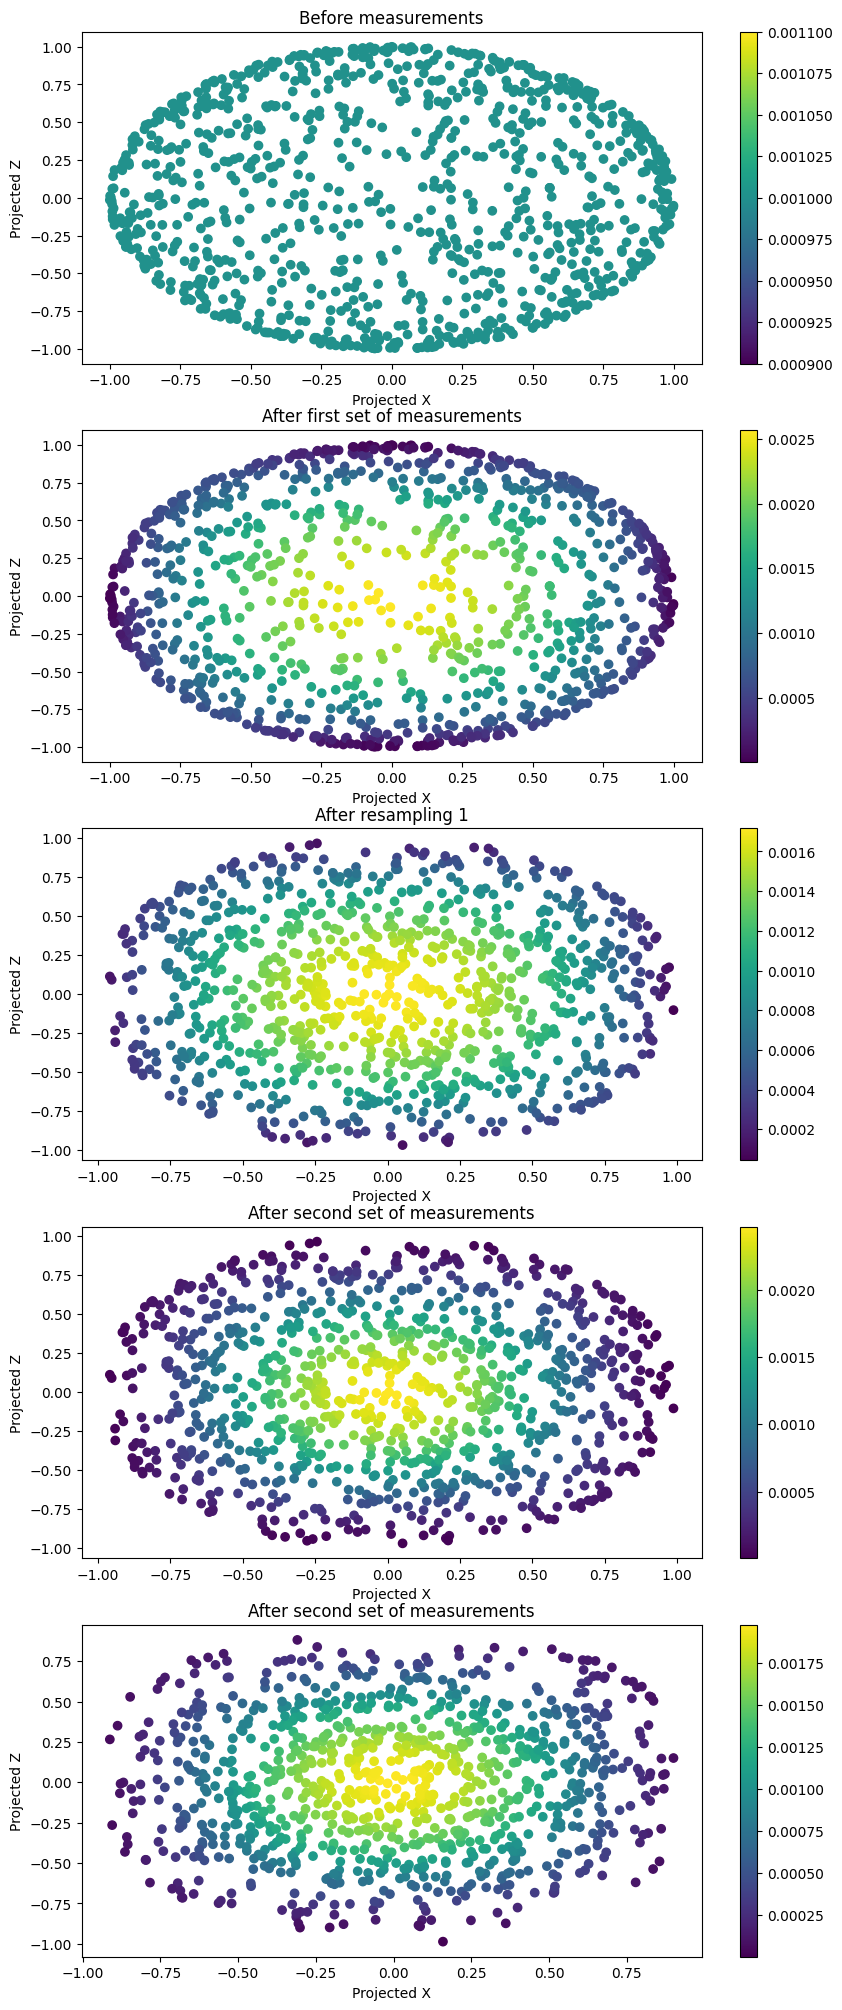

In [515]:
configurations = [[0, 0], [0, 0], [pi/2, 0], [pi/2, 0]] * 2
results = [1, 0, 1, 0] * 2
n_particles = 1000
fig, ax = plt.subplots(5, figsize = (10, 25))

particle_pos, particle_weights = initialize_particles(n_particles)

plot_xz(particle_pos, particle_weights, ax = ax[0])
ax[0].set_title(f"Before measurements")

for i in range(4):
    particle_weights = update_weights(particle_pos, particle_weights, configurations[i], results[i])
    
plot_xz(particle_pos, particle_weights, ax = ax[1])
ax[1].set_title(f"After first set of measurements")

particle_pos, particle_weights = resample(particle_pos, particle_weights, configurations[:4], results[:4], n_steps = 50)
plot_xz(particle_pos, particle_weights, ax = ax[2])
ax[2].set_title(f"After resampling 1")

for i in range(4, 8):
    particle_weights = update_weights(particle_pos, particle_weights, configurations[i], results[i])
    
plot_xz(particle_pos, particle_weights, ax = ax[3])
ax[3].set_title(f"After second set of measurements")

particle_pos, particle_weights = resample(particle_pos, particle_weights, configurations, results, n_steps = 50)
plot_xz(particle_pos, particle_weights, ax = ax[4])
ax[4].set_title(f"After second set of measurements")


## A Full QST Run
Putting together everything we've done so far, we'll try to do quantum state tomography on a random state

In [508]:
hidden_state = random_statevector(2).data
hidden_state

array([-0.42356001-0.75089829j,  0.46296841-0.20593426j])

First, we'll do it with randomly chosen axis; at every step, we'll either measure along the x, y or z axis. 

In [510]:
import random

n_measurements = 1000
possible_configs = [[0, 0], [pi/2, 0], [pi/2, pi/2]] #z, x, and y measurements
n_particles = 1000
resample_limit = 0.1 * n_particles

config_arr = []
result_arr = []

particle_states, particle_weights = initialize_particles(n_particles)

for i in range(n_measurements):
    config = random.choice(possible_configs)
    result = measure_along_axis(hidden_state, config)
    
    config_arr.append(config)
    result_arr.append(result)
    
    particle_weights = update_weights(particle_states, particle_weights, config, result)
    
    if effective_sample_size(particle_weights) < resample_limit:
        print(f"Resample triggered at step {i}")
        particle_states, particle_weights = resample(particle_states, particle_weights, 
                                                  config_arr, result_arr, 
                                                  n_steps = 50)


Resample triggered at step 22
Resample triggered at step 291


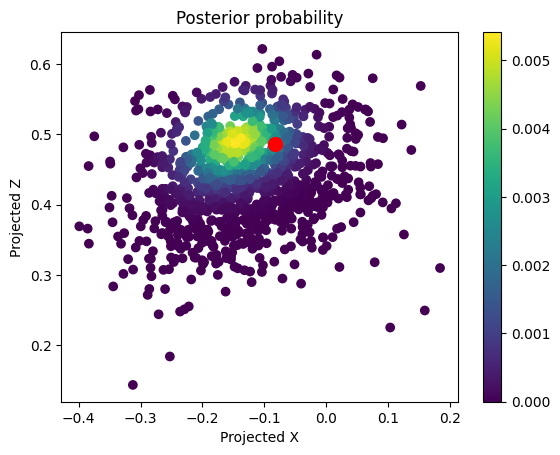

In [511]:
fig, ax = plt.subplots()
plot_xz(particle_states, particle_weights, ax = ax)

x, z = project(hidden_state)
ax.scatter([x], [z], color = "red", s = 100)

Now, let's do it with the information-maximizing choice:

In [520]:
n_measurements = 1000
n_particles = 1000
resample_limit = 0.1 * n_particles

config_arr = []
result_arr = []

particle_states, particle_weights = initialize_particles(n_particles)

for i in range(n_measurements):
    config = maximize_info_gain(particle_states, particle_weights)
    result = measure_along_axis(hidden_state, config)
    
    config_arr.append(config)
    result_arr.append(result)
    
    particle_weights = update_weights(particle_states, particle_weights, config, result)
    
    if effective_sample_size(particle_weights) < resample_limit:
        print(f"Resample triggered at step {i}")
        print(f"Effective sample size before: {effective_sample_size(particle_weights)}")
        particle_states, particle_weights = resample(particle_states, particle_weights, 
                                                  config_arr, result_arr, 
                                                  n_steps = 50)
        
        print(f"Effective sample size after: {effective_sample_size(particle_weights)}")

Resample triggered at step 19
Effective sample size before: 97.12597408569769
Effective sample size after: 770.6827097034061
Resample triggered at step 101
Effective sample size before: 99.25305233196794
Effective sample size after: 742.9225399933308
Resample triggered at step 674
Effective sample size before: 99.93860960327169
Effective sample size after: 766.6137871449496


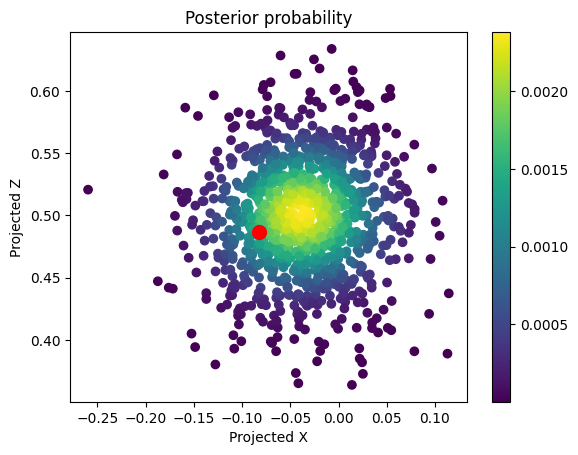

In [521]:
fig, ax = plt.subplots()
plot_xz(particle_states, particle_weights, ax = ax)

x, z = project(hidden_state)
ax.scatter([x], [z], color = "red", s = 100)